In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report
from keras.models import load_model
import tensorflow as tf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
!dir

 Volume in drive D is Data
 Volume Serial Number is 86AA-243D

 Directory of d:\Binar Academy - Data Science\challenge_platinum\challenge_platinum_binar_academy\collabs_result

27/03/2023  08:43    <DIR>          .
07/03/2023  12:49    <DIR>          ..
27/03/2023  15:23            35.218 app.py
21/03/2023  20:45             5.532 catatan.txt
27/03/2023  15:05           151.605 challenge_platinum.ipynb
15/04/2020  14:27         1.858.473 data.csv
10/03/2023  15:49    <DIR>          dict
07/03/2023  12:44             1.731 function_script.py
20/03/2023  18:54            18.693 Kerangka Report.docx
26/03/2023  17:09           168.132 notebook_davinca_EDA.ipynb
27/03/2023  14:33        29.397.840 sentiment_analysis_feedForward_neuralNetwork.h5
26/03/2023  22:27        18.241.392 sentiment_analysis_model_challenge.h5
16/03/2023  17:32        24.058.408 sentiment_analysis_model_CNN_challenge.h5
27/03/2023  15:13    <DIR>          templates
01/03/2023  09:52           221.297 test_data.csv
0

In [72]:
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

In [73]:
df_train.labels.value_counts()

positive    5790
negative    3083
neutral     1027
Name: labels, dtype: int64

In [74]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

### Oversampling pada Labels, karena imbalance

In [75]:
# inisiasi RandomOverSampler
ros = RandomOverSampler(random_state=42)

# lakukan oversampling pada kolom "tweets" dan "labels" dengan memanggil fungsi fit_resample()
X_resampled, y_resampled = ros.fit_resample(df_train[['tweets']], df_train['labels'])

# gabungkan data yang sudah di-resample menjadi sebuah dataframe baru
df_train = pd.concat([pd.DataFrame(X_resampled, columns=['tweets']), pd.DataFrame(y_resampled, columns=['labels'])], axis=1)

# print jumlah label pada dataframe yang sudah di-resample
print(df_train['labels'].value_counts())

positive    5790
negative    5790
neutral     5790
Name: labels, dtype: int64


In [76]:
df_test

,tweets,labels
0,nasi liwet asep stroberi 1 yang terletak di ja...,positive
1,tolong dipercepat lagi pengiriman nya .,negative
2,"handphone saya lenovo , kecemplung di comberan...",positive
3,ini suki and barbeque versi murah meriah . lum...,positive
4,mau melihat bandung dari atas ? nah ini tempat...,positive
...,...,...
1095,mau petik stroberi nya tetapi ternyata sedang ...,positive
1096,yang benar saja masa nomer whatsapp saya di bl...,negative
1097,food court yang memiliki berbagai macam piliha...,positive
1098,"gorengan basi dihidangkan , selera murahan",negative


In [77]:
print(df_train, df_test)

                                                  tweets    labels
0      tempat yang nyaman untuk berkumpul dengan tema...  positive
1      memang banyak bacot sih , omongan doang gede b...  negative
2      buat yang berkunjung ke bandung , yang ingin m...  positive
3      restoran menyajikan makanan khas sunda yang en...  positive
4      kalau travelling ke bandung , wajib makan bata...  positive
...                                                  ...       ...
17365  wagub sandiuno : metro tv jangan fake news men...   neutral
17366  saya ingat banyak sekali dulu yang bertubi-ber...   neutral
17367    rumah itu memiliki pagar besar berwarna hitam .   neutral
17368  usung khofifah - emil , demokrat jalin komunik...   neutral
17369  ganjar tak ingin ambil pusing walaupun banyak ...   neutral

[17370 rows x 2 columns]                                                  tweets    labels
0     nasi liwet asep stroberi 1 yang terletak di ja...  positive
1               tolong dipercepat lagi

In [78]:
def cleansing(text):
    # Make sentence being lowercase
    text = text.lower()

    # Remove user, rt, \n, retweet, \t, url, xd
    pattern_1 = r'(user|retweet|\\t|\\r|url|xd)'
    text = re.sub(pattern_1, '', text)

    # Remove mention
    pattern_2 = r'@[^\s]+'
    text = re.sub(pattern_2, '', text)

    # Remove hashtag
    pattern_3 = r'#([^\s]+)'
    text = re.sub(pattern_3, '', text)

    # Remove general punctuation, math operation char, etc.
    pattern_4 = r'[\,\@\*\_\-\!\:\;\?\'\.\"\)\(\{\}\<\>\+\%\$\^\#\/\`\~\|\&\|]'
    text = re.sub(pattern_4, ' ', text)

    # Remove single character
    pattern_5 = r'\b\w{1,3}\b'
    text = re.sub(pattern_5, '', text)

    # Remove emoji
    pattern_6 = r'\\[a-z0-9]{1,5}'
    text = re.sub(pattern_6, '', text)

    # Remove digit character
    pattern_7 = r'\d+'
    text = re.sub(pattern_7, '', text)

    # Remove url start with http or https
    pattern_8 = r'(https|https:)'
    text = re.sub(pattern_8, '', text)

    # Remove (\); ([); (])
    pattern_9 = r'[\\\]\[]'
    text = re.sub(pattern_9, '', text)

    # Remove character non ASCII
    pattern_10 = r'[^\x00-\x7f]'
    text = re.sub(pattern_10, '', text)

    # Remove character non ASCII
    pattern_11 = r'(\\u[0-9A-Fa-f]+)'
    text = re.sub(pattern_11, '', text)

    # Remove multiple whitespace
    pattern_12 = r'(\s+|\\n)'
    text = re.sub(pattern_12, ' ', text)
    
    # Remove whitespace at the first and end sentences
    text = text.rstrip()
    text = text.lstrip()
    return text

def tokenisasi(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [79]:
df_train['clean_tweets'] = df_train['tweets'].apply(cleansing)
df_test['clean_tweets'] = df_test['tweets'].apply(cleansing)

In [80]:
df_train['word_tokens'] = df_train['clean_tweets'].apply(tokenisasi)
df_test['word_tokens'] = df_test['clean_tweets'].apply(tokenisasi)

In [81]:
df_train[['clean_tweets']][0:10]

,clean_tweets
0,tempat yang nyaman untuk berkumpul dengan tema...
1,memang banyak bacot omongan doang gede bocah k...
2,buat yang berkunjung bandung yang ingin mencob...
3,restoran menyajikan makanan khas sunda yang en...
4,kalau travelling bandung wajib makan batagor r...
5,mengurus kampung menata kota demiz demul ahli
6,menyajikan aneka macam ikan bakar disajikan de...
7,terletak jalan cipaganti bandung seberang bens...
8,jokowi adalah satu satunya presiden yang tidak...
9,alhamdulillah


## One Hot Encoding

In [82]:
le = LabelEncoder()

df_train['label_encode'] = le.fit_transform(df_train['labels'])
df_test['label_encode'] = le.transform(df_test['labels'])

display(df_train.head())

print(df_train.dtypes)

,tweets,labels,clean_tweets,word_tokens,label_encode
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2
1,"memang banyak bacot sih , omongan doang gede b...",negative,memang banyak bacot omongan doang gede bocah k...,"[memang, banyak, bacot, omongan, doang, gede, ...",0
2,"buat yang berkunjung ke bandung , yang ingin m...",positive,buat yang berkunjung bandung yang ingin mencob...,"[buat, yang, berkunjung, bandung, yang, ingin,...",2
3,restoran menyajikan makanan khas sunda yang en...,positive,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2
4,"kalau travelling ke bandung , wajib makan bata...",positive,kalau travelling bandung wajib makan batagor r...,"[kalau, travelling, bandung, wajib, makan, bat...",2


tweets          object
labels          object
clean_tweets    object
word_tokens     object
label_encode     int32
dtype: object


In [83]:
df_train.isna().sum()

tweets          0
labels          0
clean_tweets    0
word_tokens     0
label_encode    0
dtype: int64

In [84]:
# Menggabungkan setiap elemen dalam kolom 'word_tokens' menjadi satu string
df_train['string_tokens'] = df_train['word_tokens'].apply(' '.join)

In [85]:
df_train

,tweets,labels,clean_tweets,word_tokens,label_encode,string_tokens
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2,tempat yang nyaman untuk berkumpul dengan tema...
1,"memang banyak bacot sih , omongan doang gede b...",negative,memang banyak bacot omongan doang gede bocah k...,"[memang, banyak, bacot, omongan, doang, gede, ...",0,memang banyak bacot omongan doang gede bocah k...
2,"buat yang berkunjung ke bandung , yang ingin m...",positive,buat yang berkunjung bandung yang ingin mencob...,"[buat, yang, berkunjung, bandung, yang, ingin,...",2,buat yang berkunjung bandung yang ingin mencob...
3,restoran menyajikan makanan khas sunda yang en...,positive,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2,restoran menyajikan makanan khas sunda yang en...
4,"kalau travelling ke bandung , wajib makan bata...",positive,kalau travelling bandung wajib makan batagor r...,"[kalau, travelling, bandung, wajib, makan, bat...",2,kalau travelling bandung wajib makan batagor r...
...,...,...,...,...,...,...
17365,wagub sandiuno : metro tv jangan fake news men...,neutral,wagub sandiuno metro jangan fake news mengikut...,"[wagub, sandiuno, metro, jangan, fake, news, m...",1,wagub sandiuno metro jangan fake news mengikut...
17366,saya ingat banyak sekali dulu yang bertubi-ber...,neutral,saya ingat banyak sekali dulu yang bertubi ber...,"[saya, ingat, banyak, sekali, dulu, yang, bert...",1,saya ingat banyak sekali dulu yang bertubi ber...
17367,rumah itu memiliki pagar besar berwarna hitam .,neutral,rumah memiliki pagar besar berwarna hitam,"[rumah, memiliki, pagar, besar, berwarna, hitam]",1,rumah memiliki pagar besar berwarna hitam
17368,"usung khofifah - emil , demokrat jalin komunik...",neutral,usung khofifah emil demokrat jalin komunikasi ...,"[usung, khofifah, emil, demokrat, jalin, komun...",1,usung khofifah emil demokrat jalin komunikasi ...


## Cek kata-kata dalam data frame yang tergolong ke dalam Outlier

[('yang', 10614), ('tidak', 5871), ('saya', 5316), ('dengan', 4700), ('untuk', 3999), ('enak', 3613), ('makanan', 3541), ('tempat', 3459), ('makan', 2894), ('juga', 2685)]
[('terluhatn', 1), ('cakkan', 1), ('tenar', 1), ('bergeser', 1), ('samalah', 1), ('kantuk', 1), ('baron', 1), ('siini', 1), ('ayoo', 1), ('setinggi', 1), ('sebegitu', 1), ('kecina', 1), ('pendahulu', 1), ('perencanaan', 1), ('topoki', 1), ('tots', 1), ('persentasi', 1), ('dekade', 1), ('terobosan', 1), ('vegan', 1), ('mengingkari', 1), ('khayalan', 1), ('kemakmuran', 1), ('resstoran', 1), ('memperbolehkan', 1), ('diputar', 1), ('busyeng', 1), ('tamusu', 1), ('chkcken', 1), ('seret', 1), ('knuc', 1), ('hooq', 1), ('musti', 1), ('disni', 1), ('preference', 1), ('slightly', 1), ('retas', 1), ('rieke', 1), ('nopember', 1), ('berteriak', 1), ('patwal', 1), ('culinary', 1), ('night', 1), ('odjolali', 1), ('kampun', 1), ('mesh', 1), ('dipenjuru', 1), ('wijilan', 1), ('dapet', 1), ('wusss', 1), ('andong', 1), ('foreign', 1),

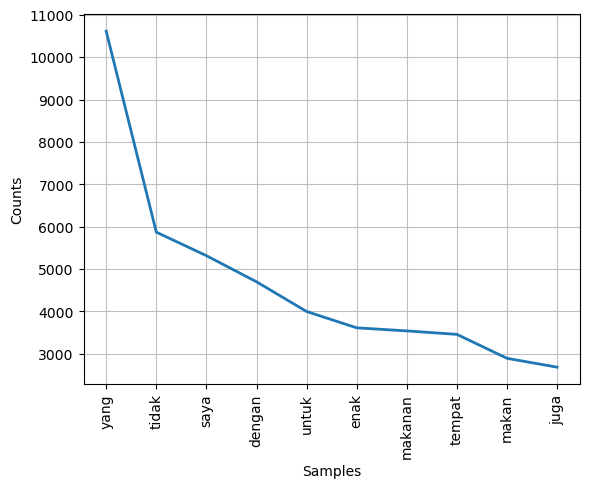

In [86]:
# determine the word from df['tweet_without_stopwords'] that occurs frequently
text = ' '.join(df_train['string_tokens'].to_list())
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))
print(freq_kata.most_common(10))
print(freq_kata.most_common()[-1000:]) # 10 kata paling sedikit muncul
freq_kata.plot(10, cumulative=False)
plt.show()

In [87]:
# get the frequency distribution of words
freq_kata = nltk.FreqDist(nltk.word_tokenize(text))

# calculate the interquartile range (IQR) of word frequency
q1, q3 = np.percentile(list(freq_kata.values()), [1, 99])
iqr = q3 - q1

# calculate the upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# get the words that are outliers
outliers = [word for word, freq in freq_kata.items() if freq > upper_bound or freq < lower_bound]
print(outliers)

['tempat', 'yang', 'nyaman', 'untuk', 'dengan', 'kalau', 'malam', 'cukup', 'enak', 'jalan', 'harga', 'banyak', 'rasanya', 'seperti', 'buat', 'bandung', 'tidak', 'makan', 'restoran', 'menu', 'sangat', 'makanan', 'rasa', 'saya', 'tapi', 'banget', 'juga', 'adalah', 'bisa', 'pelayanan', 'saja', 'dari', 'suasana', 'lebih', 'sini', 'sudah', 'kami', 'karena', 'kita', 'orang', 'sekali', 'jadi', 'sama', 'lagi']


In [88]:
# define a function to remove words from DataFrame
def remove_outliers(row):
    words = row['string_tokens'].split()
    words = [word for word in words if word not in outliers]
    return ' '.join(words)

# apply the function to the DataFrame
df_train['clean_string'] = df_train.apply(remove_outliers, axis=1)

In [89]:
df_train

,tweets,labels,clean_tweets,word_tokens,label_encode,string_tokens,clean_string
0,tempat yang nyaman untuk berkumpul dengan tema...,positive,tempat yang nyaman untuk berkumpul dengan tema...,"[tempat, yang, nyaman, untuk, berkumpul, denga...",2,tempat yang nyaman untuk berkumpul dengan tema...,berkumpul teman teman lagu lumayan kadang proy...
1,"memang banyak bacot sih , omongan doang gede b...",negative,memang banyak bacot omongan doang gede bocah k...,"[memang, banyak, bacot, omongan, doang, gede, ...",0,memang banyak bacot omongan doang gede bocah k...,memang bacot omongan doang gede bocah memang s...
2,"buat yang berkunjung ke bandung , yang ingin m...",positive,buat yang berkunjung bandung yang ingin mencob...,"[buat, yang, berkunjung, bandung, yang, ingin,...",2,buat yang berkunjung bandung yang ingin mencob...,berkunjung ingin mencoba masakan padang salah ...
3,restoran menyajikan makanan khas sunda yang en...,positive,restoran menyajikan makanan khas sunda yang en...,"[restoran, menyajikan, makanan, khas, sunda, y...",2,restoran menyajikan makanan khas sunda yang en...,menyajikan khas sunda terutama gurami terbang ...
4,"kalau travelling ke bandung , wajib makan bata...",positive,kalau travelling bandung wajib makan batagor r...,"[kalau, travelling, bandung, wajib, makan, bat...",2,kalau travelling bandung wajib makan batagor r...,travelling wajib batagor riri waktu cabang pas...
...,...,...,...,...,...,...,...
17365,wagub sandiuno : metro tv jangan fake news men...,neutral,wagub sandiuno metro jangan fake news mengikut...,"[wagub, sandiuno, metro, jangan, fake, news, m...",1,wagub sandiuno metro jangan fake news mengikut...,wagub sandiuno metro jangan fake news mengikut...
17366,saya ingat banyak sekali dulu yang bertubi-ber...,neutral,saya ingat banyak sekali dulu yang bertubi ber...,"[saya, ingat, banyak, sekali, dulu, yang, bert...",1,saya ingat banyak sekali dulu yang bertubi ber...,ingat dulu bertubi bertubi serang demokrat med...
17367,rumah itu memiliki pagar besar berwarna hitam .,neutral,rumah memiliki pagar besar berwarna hitam,"[rumah, memiliki, pagar, besar, berwarna, hitam]",1,rumah memiliki pagar besar berwarna hitam,rumah memiliki pagar besar berwarna hitam
17368,"usung khofifah - emil , demokrat jalin komunik...",neutral,usung khofifah emil demokrat jalin komunikasi ...,"[usung, khofifah, emil, demokrat, jalin, komun...",1,usung khofifah emil demokrat jalin komunikasi ...,usung khofifah emil demokrat jalin komunikasi ...


In [90]:
df_train['clean_string_tokens'] = df_train['clean_string'].apply(tokenisasi)

In [91]:
# define a function to count the number of words in a string
def count_words(text):
    words = text.split()
    return len(words)

# apply the function to the DataFrame
df_train['num_words'] = df_train['clean_string'].apply(count_words)

# calculate the average number of words per row
avg_words = df_train['num_words'].mean()

print("Average number of words per row: ", avg_words)

Average number of words per row:  13.7657455382844


In [92]:
df_train_copy = df_train.copy()
df_train_copy.drop(columns=["tweets", "labels"], inplace=True)

## LSTM

In [93]:
MAX_NB_WORDS = 15000
MAX_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 100

In [94]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

In [95]:
tokenizer.fit_on_texts(df_train_copy['word_tokens'])

# Tokenisasi data train
X_train = tokenizer.texts_to_sequences(df_train_copy['word_tokens'])
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
Y_train = pd.get_dummies(df_train_copy['label_encode']).values

# Tokenisasi data test
X_test = tokenizer.texts_to_sequences(df_test['word_tokens'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
Y_test = pd.get_dummies(df_test['label_encode']).values

In [96]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# Split data train
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.10, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(15633, 64) (15633, 3)
(1737, 64) (1737, 3)


In [29]:
# Membuat model LSTM
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

epochs = 50
batch_size = 64

# Training model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[es])

Epoch 1/50
220/220 [==============================] - 40s 161ms/step - loss: 0.5684 - accuracy: 0.7826 - val_loss: 0.2587 - val_accuracy: 0.9028
Epoch 2/50
220/220 [==============================] - 35s 161ms/step - loss: 0.1899 - accuracy: 0.9412 - val_loss: 0.1695 - val_accuracy: 0.9457
Epoch 3/50
220/220 [==============================] - 32s 147ms/step - loss: 0.1042 - accuracy: 0.9697 - val_loss: 0.1836 - val_accuracy: 0.9437
Epoch 4/50
220/220 [==============================] - 32s 147ms/step - loss: 0.0699 - accuracy: 0.9795 - val_loss: 0.1726 - val_accuracy: 0.9482
Epoch 5/50
220/220 [==============================] - 32s 145ms/step - loss: 0.0519 - accuracy: 0.9839 - val_loss: 0.1997 - val_accuracy: 0.9495
Epoch 6/50
220/220 [==============================] - 33s 148ms/step - loss: 0.0444 - accuracy: 0.9860 - val_loss: 0.2119 - val_accuracy: 0.9463
Epoch 7/50
220/220 [==============================] - 32s 147ms/step - loss: 0.0387 - accuracy: 0.9871 - val_loss: 0.2167 - val_ac

### Validation

In [30]:
y_pred = model.predict(X_val)
y_pred.shape

55/55 [==============================] - 1s 16ms/step


(1737, 3)

In [31]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.16%


In [32]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_val_classes = np.argmax(Y_val, axis=1)
print(classification_report(Y_val_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       584
           1       0.98      1.00      0.99       577
           2       0.95      0.91      0.93       576

    accuracy                           0.95      1737
   macro avg       0.95      0.95      0.95      1737
weighted avg       0.95      0.95      0.95      1737



### Predict data test

In [33]:
y_pred = model.predict(X_test)
y_pred.shape

35/35 [==============================] - 1s 16ms/step


(1100, 3)

In [34]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.91%


In [35]:
y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       353
           1       0.71      0.64      0.67       121
           2       0.89      0.90      0.90       626

    accuracy                           0.84      1100
   macro avg       0.79      0.78      0.79      1100
weighted avg       0.84      0.84      0.84      1100



In [36]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[356 109 635]


In [37]:
y_pred_sentiment = y_pred.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_test["label_prediksi"] = [labels[pred] for pred in y_pred_sentiment]

In [38]:
df_test

,tweets,labels,clean_tweets,word_tokens,label_encode,label_prediksi
0,nasi liwet asep stroberi 1 yang terletak di ja...,positive,nasi liwet asep stroberi yang terletak jalan n...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2,positive
1,tolong dipercepat lagi pengiriman nya .,negative,tolong dipercepat lagi pengiriman,"[tolong, dipercepat, lagi, pengiriman]",0,negative
2,"handphone saya lenovo , kecemplung di comberan...",positive,handphone saya lenovo kecemplung comberan ming...,"[handphone, saya, lenovo, kecemplung, comberan...",2,positive
3,ini suki and barbeque versi murah meriah . lum...,positive,suki barbeque versi murah meriah lumayan bange...,"[suki, barbeque, versi, murah, meriah, lumayan...",2,positive
4,mau melihat bandung dari atas ? nah ini tempat...,positive,melihat bandung dari atas tempat walaupun harg...,"[melihat, bandung, dari, atas, tempat, walaupu...",2,positive
...,...,...,...,...,...,...
1095,mau petik stroberi nya tetapi ternyata sedang ...,positive,petik stroberi tetapi ternyata sedang tidak mu...,"[petik, stroberi, tetapi, ternyata, sedang, ti...",2,positive
1096,yang benar saja masa nomer whatsapp saya di bl...,negative,yang benar saja masa nomer whatsapp saya blok ...,"[yang, benar, saja, masa, nomer, whatsapp, say...",0,negative
1097,food court yang memiliki berbagai macam piliha...,positive,food court yang memiliki berbagai macam piliha...,"[food, court, yang, memiliki, berbagai, macam,...",2,positive
1098,"gorengan basi dihidangkan , selera murahan",negative,gorengan basi dihidangkan selera murahan,"[gorengan, basi, dihidangkan, selera, murahan]",0,positive


## Save Model

In [39]:
model.save("sentiment_analysis_model_challenge.h5")

## Cara menggunakan model kembali dengan load model

In [40]:
# load data baru
df_new = pd.read_csv("test_data.csv")
df_new = df_new.applymap(cleansing)
# df_new = df_new.applymap(remove_stopwords)

sentences = df_new['tweets']
df_new['label_encoded'] = le.transform(df_new['labels'])
df_new_labels = pd.get_dummies(df_new['label_encoded']).values

# lakukan preprocessing pada data baru
X_new = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(X_new, maxlen=MAX_SEQUENCE_LENGTH)

loaded_model = load_model("sentiment_analysis_model_challenge.h5")

# lakukan prediksi pada data baru
y_prob = loaded_model.predict(X_new)
y_pred = y_prob.argmax(axis=-1)

# konversi nilai prediksi menjadi label sentimen
labels = {0: "negative", 1: "neutral", 2: "positive"}
df_new["label_sentimen"] = [labels[pred] for pred in y_pred]

35/35 [==============================] - 2s 38ms/step


### Cek akurasi prediksi label terhadap label original

In [41]:
y_pred_classes = np.argmax(y_prob, axis=1)
Y_val_classes = np.argmax(df_new_labels, axis=1)
accuracy = accuracy_score(Y_val_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.91%


In [42]:
y_pred_classes = np.argmax(y_prob, axis=1)
Y_test_classes = np.argmax(df_new_labels, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       353
           1       0.71      0.64      0.67       121
           2       0.89      0.90      0.90       626

    accuracy                           0.84      1100
   macro avg       0.79      0.78      0.79      1100
weighted avg       0.84      0.84      0.84      1100



In [43]:
df_new.label_sentimen.value_counts()

positive    635
negative    356
neutral     109
Name: label_sentimen, dtype: int64

In [44]:
df_new

,tweets,labels,label_encoded,label_sentimen
0,nasi liwet asep stroberi yang terletak jalan n...,positive,2,positive
1,tolong dipercepat lagi pengiriman,negative,0,negative
2,handphone saya lenovo kecemplung comberan ming...,positive,2,positive
3,suki barbeque versi murah meriah lumayan bange...,positive,2,positive
4,melihat bandung dari atas tempat walaupun harg...,positive,2,positive
...,...,...,...,...
1095,petik stroberi tetapi ternyata sedang tidak mu...,positive,2,positive
1096,yang benar saja masa nomer whatsapp saya blok ...,negative,0,negative
1097,food court yang memiliki berbagai macam piliha...,positive,2,positive
1098,gorengan basi dihidangkan selera murahan,negative,0,positive


# CNN

In [661]:
# Load data
#data = pd.read_csv("train_preprocess.tsv.txt", sep="\t", engine="python", names=["data", "label"])
sentences = df_train['word_tokens'].to_list()
labels = df_train['label_encode']

# Convert labels to numeric values
#label_dict = {"negative": 0, "neutral": 1, "positive": 2}
#labels = np.array([label_dict[label] for label in labels])
#labels = np.array([labels])

# Tokenize data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=64)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, labels, test_size=0.2)

# One-hot encode the labels
Y_train = tf.keras.utils.to_categorical(Y_train, 3)
Y_test = tf.keras.utils.to_categorical(Y_test, 3)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=64),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 2
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print("Test accuracy:", test_acc)

Epoch 1/2
435/435 [==============================] - 20s 43ms/step - loss: 0.4137 - accuracy: 0.8308 - val_loss: 0.1811 - val_accuracy: 0.9396
Epoch 2/2
435/435 [==============================] - 17s 40ms/step - loss: 0.0821 - accuracy: 0.9728 - val_loss: 0.1291 - val_accuracy: 0.9516
109/109 - 1s - loss: 0.1291 - accuracy: 0.9516 - 503ms/epoch - 5ms/step
Test accuracy: 0.951640784740448


In [24]:
model.save("sentiment_analysis_model_CNN_challenge.h5")

# Feed Forward Neural Network

In [21]:
# load data
df = pd.read_csv('train_data.csv')

# preprocessing data
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['labels'])
df['tweets'] = df['tweets'].apply(cleansing)

from imblearn.over_sampling import RandomOverSampler

# inisiasi RandomOverSampler
ros = RandomOverSampler(random_state=42)

# lakukan oversampling pada kolom "tweets" dan "labels" dengan memanggil fungsi fit_resample()
X_resampled, y_resampled = ros.fit_resample(df[['tweets']], df['labels'])

# gabungkan data yang sudah di-resample menjadi sebuah dataframe baru
df = pd.concat([pd.DataFrame(X_resampled, columns=['tweets']), pd.DataFrame(y_resampled, columns=['labels'])], axis=1)

# split data into train and test
train_text, test_text, train_label, test_label = train_test_split(df['tweets'], df['labels'], test_size=0.2, random_state=42)

# tokenizing data
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)

# padding data
train_pad = pad_sequences(train_seq, maxlen=64)
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

# define model
model = Sequential([
    Embedding(input_dim=15000, output_dim=128, input_length=64),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping callback
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# train model
model.fit(train_pad, train_label, epochs=50, batch_size=32, validation_data=(test_pad, test_label), callbacks=[es])

# evaluate model
test_loss, test_acc = model.evaluate(test_pad, test_label)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/50
435/435 [==============================] - 21s 47ms/step - loss: 0.6504 - accuracy: 0.7103 - val_loss: 0.2177 - val_accuracy: 0.9211
Epoch 2/50
435/435 [==============================] - 20s 46ms/step - loss: 0.1695 - accuracy: 0.9485 - val_loss: 0.1481 - val_accuracy: 0.9467
Epoch 3/50
435/435 [==============================] - 21s 49ms/step - loss: 0.0648 - accuracy: 0.9816 - val_loss: 0.1707 - val_accuracy: 0.9551
Epoch 4/50
435/435 [==============================] - 29s 66ms/step - loss: 0.0317 - accuracy: 0.9899 - val_loss: 0.2137 - val_accuracy: 0.9528
Epoch 5/50
435/435 [==============================] - 20s 46ms/step - loss: 0.0195 - accuracy: 0.9929 - val_loss: 0.2575 - val_accuracy: 0.9505
Epoch 6/50
435/435 [==============================] - 20s 47ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.3188 - val_accuracy: 0.9537
Epoch 7/50
435/435 [==============================] - 20s 47ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.3564 - val_accuracy:

In [22]:
model.save("sentiment_analysis_feedForward_neuralNetwork.h5")

## Cek akurasi saat model digunakan pada data test_data.csv

In [38]:
X_test_ffnn = pd.read_csv("test_data.csv")

# preprocessing data
encoder = LabelEncoder()
X_test_ffnn['labels'] = le.transform(X_test_ffnn['labels'])
X_test_ffnn['tweets'] = X_test_ffnn['tweets'].apply(cleansing)

# tokenizing data
test_seq = tokenizer.texts_to_sequences(X_test_ffnn['tweets'])

# padding data
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
test_label = to_categorical(X_test_ffnn['labels'])

In [39]:
y_pred = model.predict(test_pad)
y_pred.shape

35/35 [==============================] - 1s 19ms/step


(1100, 3)

In [40]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.82%


In [41]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       353
           1       0.78      0.61      0.69       121
           2       0.90      0.90      0.90       626

    accuracy                           0.85      1100
   macro avg       0.82      0.78      0.80      1100
weighted avg       0.85      0.85      0.85      1100



In [43]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[377  95 628]


In [44]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

In [47]:
df_test.head()

,tweets,labels,clean_tweets,word_tokens,label_encode
0,nasi liwet asep stroberi 1 yang terletak di ja...,positive,nasi liwet asep stroberi yang terletak jalan n...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2
1,tolong dipercepat lagi pengiriman nya .,negative,tolong dipercepat lagi pengiriman,"[tolong, dipercepat, lagi, pengiriman]",0
2,"handphone saya lenovo , kecemplung di comberan...",positive,handphone saya lenovo kecemplung comberan ming...,"[handphone, saya, lenovo, kecemplung, comberan...",2
3,ini suki and barbeque versi murah meriah . lum...,positive,suki barbeque versi murah meriah lumayan bange...,"[suki, barbeque, versi, murah, meriah, lumayan...",2
4,mau melihat bandung dari atas ? nah ini tempat...,positive,melihat bandung dari atas tempat walaupun harg...,"[melihat, bandung, dari, atas, tempat, walaupu...",2


## Menggunakan kembali model FFNN dengan load_model

In [58]:
X_test_ffnn = pd.read_csv("test_data.csv")

# preprocessing data
encoder = LabelEncoder()
X_test_ffnn['labels'] = le.transform(X_test_ffnn['labels'])
X_test_ffnn['tweets'] = X_test_ffnn['tweets'].apply(cleansing)

# tokenizing data
test_seq = tokenizer.texts_to_sequences(X_test_ffnn['tweets'])

# padding data
test_pad = pad_sequences(test_seq, maxlen=64)

# convert label to categorical
test_label = to_categorical(X_test_ffnn['labels'])

In [59]:
loaded_model_ffnn = load_model("sentiment_analysis_feedForward_neuralNetwork.h5")

In [60]:
y_pred = loaded_model_ffnn.predict(test_pad)
y_pred.shape

35/35 [==============================] - 0s 5ms/step


(1100, 3)

In [61]:
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
accuracy = accuracy_score(Y_test_classes, y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.82%


In [62]:
from sklearn.metrics import classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
Y_test_classes = np.argmax(test_label, axis=1)
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       353
           1       0.78      0.61      0.69       121
           2       0.90      0.90      0.90       626

    accuracy                           0.85      1100
   macro avg       0.82      0.78      0.80      1100
weighted avg       0.85      0.85      0.85      1100



In [63]:
unique_values, value_counts = np.unique(y_pred_classes, return_counts=True)

print(unique_values)  # [0 1 2 3]
print(value_counts)   # [1 2 3 1]

[0 1 2]
[377  95 628]


In [64]:
df_test.labels.value_counts()

positive    626
negative    353
neutral     121
Name: labels, dtype: int64

In [65]:
df_test.head()

,tweets,labels,clean_tweets,word_tokens,label_encode
0,nasi liwet asep stroberi 1 yang terletak di ja...,positive,nasi liwet asep stroberi yang terletak jalan n...,"[nasi, liwet, asep, stroberi, yang, terletak, ...",2
1,tolong dipercepat lagi pengiriman nya .,negative,tolong dipercepat lagi pengiriman,"[tolong, dipercepat, lagi, pengiriman]",0
2,"handphone saya lenovo , kecemplung di comberan...",positive,handphone saya lenovo kecemplung comberan ming...,"[handphone, saya, lenovo, kecemplung, comberan...",2
3,ini suki and barbeque versi murah meriah . lum...,positive,suki barbeque versi murah meriah lumayan bange...,"[suki, barbeque, versi, murah, meriah, lumayan...",2
4,mau melihat bandung dari atas ? nah ini tempat...,positive,melihat bandung dari atas tempat walaupun harg...,"[melihat, bandung, dari, atas, tempat, walaupu...",2
